In [3]:
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
from exact_solutions import GreenFunctionModes, Mode
from Trefft_tools import  TrefftzSpace, TrefftzFunction, AssembleMatrix, AssembleGreenRHS, AssembleRHS

import numpy as np
from scipy.sparse.linalg import spsolve as solve


from domains import Waveguide, ScattererShape, ScattererType

# Mode



working on refinement: N=3
h_max=0.4580471101557189
Initial refinement:
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=4
h_max=0.36199298260050544
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=5
h_max=0.28998965946483024
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=6
h_max=0.24691193897502972
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=7
h_max=0.2052507504617864
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=8
h_max=0.1773973634113433
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=9
h_max=0.16158061930260545
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9

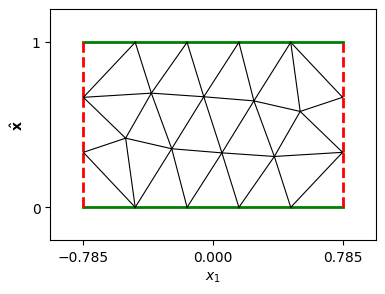

In [15]:
refinements = range(3,10,1)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
Hs = np.zeros((N_ref), dtype=np.float64)

conds = np.zeros((N_ref,N_N_th), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

factor = 16/8

kappa_e = factor*8.
lambda_e = 2*np.pi/kappa_e
R = factor*lambda_e
H = 1.


c = (0,0.6*H)



Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 3
u_exact = np.reshape( Mode( kappa_e, H, np.stack([X.ravel(),Y.ravel()], axis=1), t=t), (Ny,Nx))


for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/(N)
    hs[i] = h
   
    Domain = Waveguide(R=R,H=H) 
    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    Hs[i] = h_max
    print(f'{h_max=}')

    if i == 0:
        print('Initial refinement:')
        Domain.plot_mesh()

    for (j,Nth) in enumerate(N_ths):
        print(f"N_theta={Nth}...")
        th_0 = np.e/np.pi # no correct direction in the basis
        V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )
        N_modes = 13 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5

        A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
        # _, _, conds[i,j] = cond(A)
        B = AssembleRHS(V, Domain.Edges, kappa_e, Domain.H, d_2=d_2, t=t )

        A = A.tocsc()
        
        DOFs = solve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 


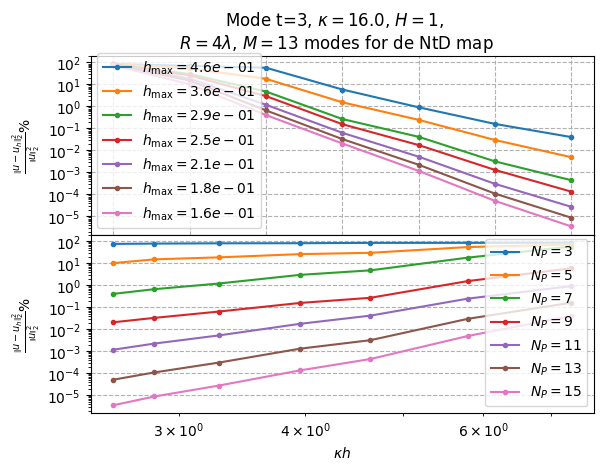

In [29]:
inches_per_dot = 1/72.27
cm2inch = 1/2.54 # inch per cm
columnwidth = 469.75502 * inches_per_dot
# # virginias slides
# columnwidth = 342.2953 * inches_per_dot

# columnwidth=columnwidth*0.9

left_margin = 1. * cm2inch # cm
right_margin = 1.*cm2inch  # cm
figure_width = columnwidth # cm
figure_height = columnwidth/1.2 # cm
top_margin = 1.*cm2inch    # cm
bottom_margin = 1.*cm2inch # cm

# box_width = left_margin + figure_width + right_margin   # cm
# box_height = top_margin + figure_height + bottom_margin # cm
box_width = columnwidth
box_height = columnwidth/1.4


fig, ax = plt.subplots(nrows=2,figsize=(box_width,box_height))

for err, h in zip(errors,Hs):
    ax[0].semilogy(N_ths,err,'.-', label=f'$h_\\mathrm{{max}} = {h: .1e}$')



fig.suptitle(f'Mode t={t}, $\\kappa={kappa_e}$, $H = {H:.0f}$,\n $R = 4\\lambda$, $M={N_modes}$ modes for de NtD map')

ax[0].set_xlabel('$N_p$')
ax[0].set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax[0].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[0].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax[0].set_xticks(range(3,17,2))
ax[0].grid(True,which="major",ls='--')
ax[0].legend(loc="lower left")


for err, N_th in zip(errors.transpose(),N_ths):
    ax[1].loglog(kappa_e*Hs,err,'.-', label=f'$N_P = {N_th}$')

ax[1].set_xlabel('$\\kappa h$')
ax[1].set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax[1].legend(loc="lower right")
ax[1].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[1].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax[1].xaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[1].xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.grid(True,which="major",ls='--')




# fig.subplots_adjust(left   = left_margin / box_width,
#                     bottom = bottom_margin / box_height,
#                     right  = 1. - right_margin / box_width,
#                     top    = 1. - top_margin   / box_height)

fig.subplots_adjust(wspace=0., hspace=0.)

plt.savefig(f'convergence_mode_t_{t}_k={int(kappa_e)}.pdf')

# Cedya Slides

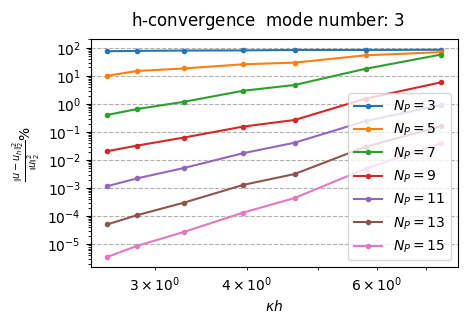

In [35]:
inches_per_dot = 1/72.27
cm2inch = 1/2.54 # inch per cm
# virginias slides
columnwidth = 342.2953 * inches_per_dot

box_width = columnwidth
box_height = columnwidth/1.6


fig, ax = plt.subplots(figsize=(box_width,box_height))
fig.suptitle(f'h-convergence  mode number: ${t}$')

for err, N_th in zip(errors.transpose(),N_ths):
    ax.loglog(kappa_e*Hs,err,'.-', label=f'$N_P = {N_th}$')

ax.set_xlabel('$\\kappa h$')
ax.set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax.legend(loc="lower right")
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.grid(True,which="major",ls='--')

fig.subplots_adjust(wspace=0., hspace=0.)

plt.savefig(f'h-convergence_mode_t_{t}_k={int(kappa_e)}.pdf')

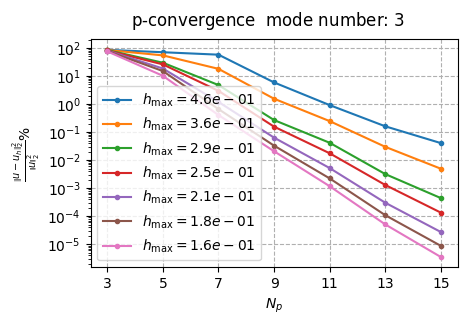

In [34]:
# p-convergence

inches_per_dot = 1/72.27
cm2inch = 1/2.54 # inch per cm
# virginias slides
columnwidth = 342.2953 * inches_per_dot

box_width = columnwidth
box_height = columnwidth/1.6


fig, ax = plt.subplots(figsize=(box_width,box_height))

for err, h in zip(errors,Hs):
    ax.semilogy(N_ths,err,'.-', label=f'$h_\\mathrm{{max}} = {h: .1e}$')



fig.suptitle(f'p-convergence  mode number: ${t}$')
ax.set_xlabel('$N_p$')
ax.set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.set_xticks(range(3,17,2))
ax.grid(True,which="major",ls='--')
ax.legend(loc="lower left")



fig.subplots_adjust(wspace=0., hspace=0.)

plt.savefig(f'p-convergence_mode_t_{t}_k={int(kappa_e)}.pdf')

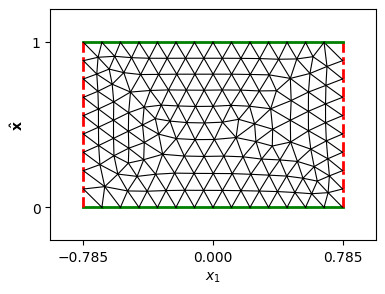

In [13]:
Domain.plot_mesh()

# Scatterer hp-convergence

working on refinement: N=3
h_max=0.4223385685436916
Initial refinement:
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=4
h_max=0.38900205060513837
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=5
h_max=0.28027333478544764
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=6
h_max=0.2511462607299692
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=7
h_max=0.2019898707748881
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=8
h_max=0.1803798998483503
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=9
h_max=0.1591277412982581
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9..

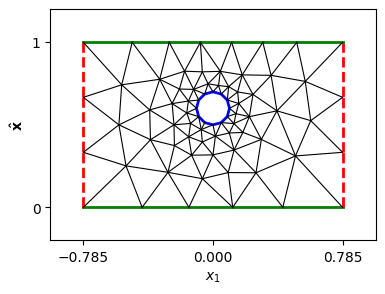

In [3]:
refinements = range(3,10,1)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
Hs = np.zeros((N_ref), dtype=np.float64)

conds = np.zeros((N_ref,N_N_th), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

factor = 32/8

kappa_e = factor*8.
lambda_e = 2*np.pi/kappa_e
R = factor*lambda_e
H = 1.


c = (0,0.6*H)

t=1

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

M = 1600
u_exact = np.reshape( GreenFunctionModes(kappa_e, H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=M), (Ny,Nx))


for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/(N)
    hs[i] = h
   
    Domain = Waveguide(R=R,H=H) 
    Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    Hs[i] = h_max
    print(f'{h_max=}')

    if i == 0:
        print('Initial refinement:')
        Domain.plot_mesh()

    for (j,Nth) in enumerate(N_ths):
        print(f"N_theta={Nth}...")
        th_0 = np.e/np.pi # no correct direction in the basis
        V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )
        N_modes = 15 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5

        A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
        # _, _, conds[i,j] = cond(A)
        B = AssembleGreenRHS(V, Domain.Edges, kappa_e, Domain.H, a=a, x_0=c[0], y_0=c[1], modes=True, M=M)

        A = A.tocsc()
        
        DOFs = solve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 


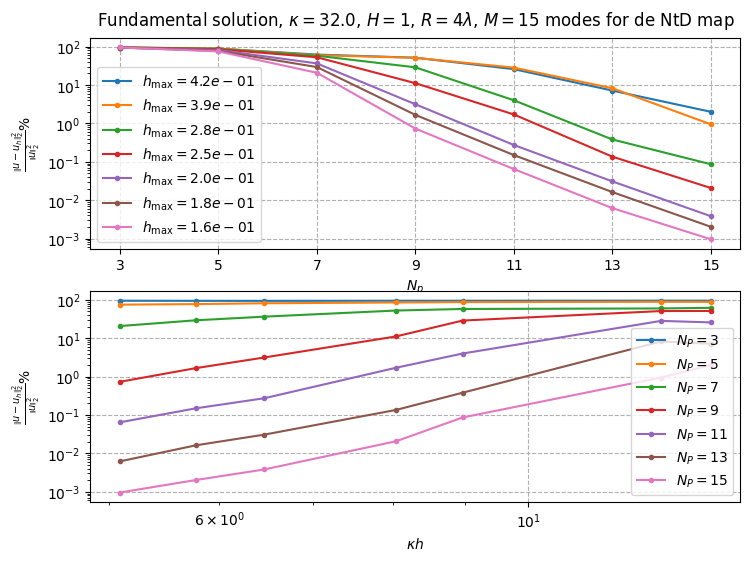

In [8]:
inches_per_dot = 1/72.27
cm2inch = 1/2.54 # inch per cm
columnwidth = 469.75502 * inches_per_dot
# virginias slides
#columnwidth = 342.2953 * inches_per_dot

# columnwidth=columnwidth*0.9

left_margin = 1. * cm2inch # cm
right_margin = 1.*cm2inch  # cm
figure_width = columnwidth # cm
figure_height = columnwidth/1.4 # cm
top_margin = 1.*cm2inch    # cm
bottom_margin = 1.*cm2inch # cm

box_width = left_margin + figure_width + right_margin   # cm
box_height = top_margin + figure_height + bottom_margin # cm



fig, ax = plt.subplots(nrows=2,figsize=(box_width,box_height))

for err, h in zip(errors,Hs):
    ax[0].semilogy(N_ths,err,'.-', label=f'$h_\\mathrm{{max}} = {h: .1e}$')



fig.suptitle(f'Fundamental solution, $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = 4\\lambda$, $M={N_modes}$ modes for de NtD map')

ax[0].set_xlabel('$N_p$')
ax[0].set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax[0].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[0].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax[0].set_xticks(range(3,17,2))
ax[0].grid(True,which="major",ls='--')
ax[0].legend()


for err, N_th in zip(errors.transpose(),N_ths):
    ax[1].loglog(kappa_e*Hs,err,'.-', label=f'$N_P = {N_th}$')

ax[1].set_xlabel('$\\kappa h$')
ax[1].set_ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
ax[1].legend(loc="lower right")
ax[1].yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax[1].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.grid(True,which="major",ls='--')




fig.subplots_adjust(left   = left_margin / box_width,
                    bottom = bottom_margin / box_height,
                    right  = 1. - right_margin / box_width,
                    top    = 1. - top_margin   / box_height)

plt.savefig("correct_h.pdf")
#plt.savefig(f'convergence_fund_k_{int( kappa_e )}.pdf')


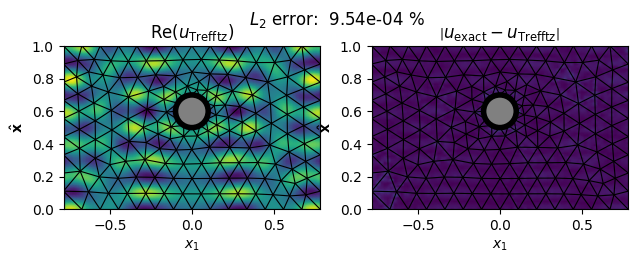

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(box_width,box_width/3))
Domain.plot_field(X,Y,np.real(u_Trefft),ax=ax[0], show_edges=True)
Domain.plot_field( X,Y,np.abs(u_Trefft-u_exact),ax=ax[1], show_edges=True)
ax[0].set_title('$\\mathrm{Re}(u_\\mathrm{Trefftz})$')
ax[1].set_title('$\\left|u_\\mathrm{exact}-u_\\mathrm{Trefftz}\\right|$')

fig.suptitle(f'$L_2$ error: {Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 : .2e} %')

plt.savefig(f'error_fund_k_{int(kappa_e)}.pdf')

In [17]:
max_modes = 15
errors = np.zeros( max_modes, dtype=np.float64)

factor = 32/8

kappa_e = factor*8.
lambda_e = 2*np.pi/kappa_e
R = factor*lambda_e
H = 1.


c = (0,0.6*H)


Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

M = 1600
u_exact = np.reshape( GreenFunctionModes(kappa_e, H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=M), (Ny,Nx))

h = H/9

for (i,N_modes) in enumerate(range(1,max_modes+1)):
    print(f"{N_modes=}")
    Domain = Waveguide(R=R,H=H) 
    Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
    Domain.generate_mesh(h_max=h)

    th_0 = np.e/np.pi # no correct direction in the basis
    V = TrefftzSpace(Domain.Omega, 15, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )
    # "UWVF" parameters
    a = 0.5
    b = 0.5
    d_1 = 0.5
    d_2 = 0.5

    A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
    # _, _, conds[i,j] = cond(A)
    B = AssembleGreenRHS(V, Domain.Edges, kappa_e, Domain.H, a=a, x_0=c[0], y_0=c[1], modes=True, M=M)

    A = A.tocsc()
    
    DOFs = solve(A,B)
    f = TrefftzFunction(V,DOFs)

    u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
    errors[i] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 


N_modes=1
N_modes=2
N_modes=3
N_modes=4
N_modes=5
N_modes=6
N_modes=7
N_modes=8
N_modes=9
N_modes=10
N_modes=11
N_modes=12
N_modes=13
N_modes=14
N_modes=15


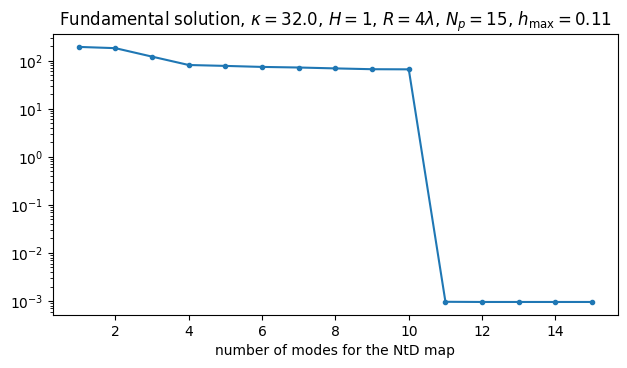

In [35]:
fig, ax = plt.subplots(figsize=(box_width,box_width/2))
plt.semilogy(range(1,max_modes+1), errors, '.-')
plt.title(f'Fundamental solution, $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = 4\\lambda$, $N_p=15$, $h_\\mathrm{{max}}=0.11$')
plt.xlabel('number of modes for the NtD map')
plt.savefig('dependeny_on_N_modes_log.pdf')

In [19]:
errors

array([1.93425365e+02, 1.82173402e+02, 1.21423872e+02, 8.12977741e+01,
       7.78764509e+01, 7.41678945e+01, 7.21034176e+01, 6.90881941e+01,
       6.64359202e+01, 6.60488643e+01, 9.62508904e-04, 9.54456535e-04,
       9.54417014e-04, 9.54347772e-04, 9.54341417e-04])

In [29]:
h

0.1111111111111111